<a href="https://colab.research.google.com/github/arnisafazla/CS490/blob/main/CS_490_notes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd /content/drive/MyDrive/CS490/CS490-Senior-Research-Project

/content/drive/MyDrive/CS490/CS490-Senior-Research-Project


In [8]:
! git pull

Already up to date.


In [ ]:
!git config --global user.email "arnisa.fazla@ug.bilkent.edu.tr"
!git config --global user.name "arnisafazla"
! git add .

In [ ]:
! git commit -m 'conditional batch normalization in generator is done. probably needs '

[main 8eb8ab0] rm another __pycache__
 1 file changed, 0 insertions(+), 0 deletions(-)
 delete mode 100644 models/__pycache__/Base_WGAN.cpython-37.pyc


In [ ]:
! git rm ./models/__pycache__/ -r

fatal: pathspec './models/__pycache__/' did not match any files


In [ ]:
! git check-ignore -v __pycache__/

.gitignore:1:__pycache__	__pycache__/


In [ ]:
! echo 'models/__pycache__' >> .gitignore

In [ ]:
! git add models/
! git add tools.py

In [ ]:
! git push origin main

Counting objects: 3, done.
Delta compression using up to 2 threads.
Compressing objects: 100% (3/3), done.
Writing objects: 100% (3/3), 298 bytes | 74.00 KiB/s, done.
Total 3 (delta 2), reused 0 (delta 0)
remote: Resolving deltas: 100% (2/2), completed with 2 local objects.
To https://github.com/arnisafazla/CS490-Senior-Research-Project.git
   7bd3480..8eb8ab0  main -> main


In [5]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras.utils.vis_utils import plot_model

# path to the cloned repo
main_dir = '/content/drive/MyDrive/CS490/CS490-Senior-Research-Project'  
# path to the dataset folder
dataset_dir = '/content/drive/MyDrive/CS490/dataset'
%cd {main_dir}
sys.path.insert(0,main_dir)
sys.path.insert(0,'/content/drive/MyDrive/CS490')
from dataset import Dataset
from models.critic_models.LSTM_critic import define_critic
from models.critic_models.projection_critic import define_projection_critic
from models.generator_models.norm_generator import define_norm_generator
from models.Base_WGAN import Base_WGAN

/content/drive/MyDrive/CS490/CS490-Senior-Research-Project


In [ ]:
# %cd ..
# !mkdir generator_models
%cd models/generator_models
! touch norm_generator.py

/content/drive/MyDrive/CS490/CS490-Senior-Research-Project/models/generator_models


In [6]:
# path is the path to the dataset
dataset = Dataset(["anger", "joy", "fear", "neutral", "sadness", "pride"], path=dataset_dir, step_size=10, frames=200)
# dataset = Dataset(["anger"], path=dataset_dir, step_size=10, frames=400)

anger


100%|██████████| 65/65 [00:10<00:00,  5.99it/s]


joy


100%|██████████| 29/29 [00:18<00:00,  1.57it/s]


fear


100%|██████████| 32/32 [00:18<00:00,  1.74it/s]


neutral


100%|██████████| 84/84 [00:37<00:00,  2.23it/s]


sadness


100%|██████████| 46/46 [00:21<00:00,  2.13it/s]


pride


100%|██████████| 24/24 [00:11<00:00,  2.12it/s]


In [7]:
Dataset.balance(dataset)

No. of samples in each class will be:  1114


In [172]:
# save this as a separate file
config = {       # change hyperparams here
        'latent_dim' : 400,
        'in_shape' : (200,69),   #(dataset.frames, 69),
        'n_classes' : 6,            # dataset.emotions.shape[0],
        'init_std' : 0.01,
        'epochs' : 20,
        'batch_size' : 128,
        'n_critic' : 1,
        'dataset_balanced' : True,
        'critic_batch_norm' : True,
        'critic_instance_norm' : False,
        'critic_layer_norm' : False,
        'critic_weight_norm' : False,
        'critic_dropout' : 0,
        'gp_weight' : 10.0      # for the gradient penalty used in critic
        # 'avg_alpha' : 0.5        # for moving average in conditional batch norm layer in generator
      }

In [188]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import utils
  
class ConditionalBatchNorm(layers.Layer):
  def build(self, input_shape):
    self.seq_len = 69
    self.n_classes = 6
    self.gamma = self.add_weight(shape=[self.n_classes, self.seq_len], 
        initializer='zeros', trainable=True, name='gamma')
    self.beta = self.add_weight(shape=[self.n_classes, self.seq_len], 
        initializer='zeros', trainable=True, name='beta')
    self.moving_mean = self.add_weight(shape=[1, self.seq_len],
        initializer='zeros', trainable=False, name='moving_mean')
    self.moving_var = self.add_weight(shape=[1, self.seq_len], 
        initializer='zeros', trainable=False, name='moving_var')
    self.alpha = 0.99  # alpha is the decay parameter for exponential moving average
    # it is 0.99 in keras.layers.BatchNormalization so I use it too.
    self.eps = 0.00001  # only for prevent dividing by 0. keras.layers.BatchNormalization use 0.001, I use smaller for safer
  def call(self, inputs, training=False):
    x, labels = tf.split(inputs, [self.seq_len, 1], axis=1)
    labels = tf.cast(labels, tf.int32)
    beta = tf.gather(self.beta, labels)
    # print(beta)
    beta = tf.reshape(beta, (-1, beta.shape[-1]))
    # print(beta)
    gamma = tf.gather(self.gamma, labels)
    gamma = tf.reshape(gamma, (-1, gamma.shape[-1]))
    if training:
      mean, var = tf.nn.moments(x, axes=(0), keepdims=True)
      self.moving_mean.assign(self.alpha * self.moving_mean + (1-self.alpha)*mean)
      self.moving_var.assign(self.alpha * self.moving_var + (1-self.alpha)*var)
      # mean = tf.repeat(mean, labels.shape[0], axis=0)
      # var = tf.repeat(var, labels.shape[0], axis=0)
      # print(x.shape, mean.shape, var.shape, beta.shape, gamma.shape)
      output = tf.nn.batch_normalization(x, mean, var, beta, gamma, self.eps)
    else:
      output = tf.nn.batch_normalization(x, self.moving_mean, self.moving_var, beta, gamma, self.eps)
    return output
  def compute_output_shape(self, input_shape):
    return (None, self.seq_len)
  
def define_generator(config):
  init = keras.initializers.RandomNormal(stddev=config['init_std'])
  in_label = layers.Input(shape=(1,), name='label_input')
  # li = layers.CategoryEncoding(num_tokens=config['n_classes'], output_mode="one_hot", name='one-hot')(in_label)
  li = layers.RepeatVector(config['in_shape'][0], name='repeat')(in_label)

  in_lat = layers.Input(shape=(config['latent_dim'],), name='seq_input')
  lat = layers.Dense(config['in_shape'][0] * config['in_shape'][1], name='lat_upsample')(in_lat)
  lat = layers.Reshape((config['in_shape'][0], config['in_shape'][1]))(lat)
  # merge = keras.layers.Concatenate(name='concatenate', axis=2)([li, lat])

  hidden1 = layers.LSTM(config['in_shape'][1], name='hidden1', return_sequences=True, kernel_initializer=init)(lat)
  merged = layers.Concatenate(axis=2, name='concatenate')([hidden1, li])
  hidden1 = layers.TimeDistributed(ConditionalBatchNorm(name='conditional_batch_norm'))(merged)
  hidden2 = layers.LSTM(config['in_shape'][1], name='out_LSTM', return_sequences=True, kernel_initializer=init)(hidden1)
  merged2 = layers.Concatenate(axis=2, name='concatenate2')([hidden2, li])
  out = layers.TimeDistributed(ConditionalBatchNorm(name='conditional_batch_norm2'))(merged2)
  model = keras.Model([in_label, in_lat], out, name='generator')
  return model

In [148]:
x = tf.convert_to_tensor(np.ones((128,69)))
mean = tf.convert_to_tensor(np.ones((1, 69)))
var = tf.convert_to_tensor(np.ones((1,69)))
beta = tf.convert_to_tensor(np.ones((128, 1, 69)))
gamma = tf.convert_to_tensor(np.ones((128, 1, 69)))
output = tf.nn.batch_normalization(x, mean, var, beta, gamma, 0.99)

In [149]:
output

<tf.Tensor: shape=(128, 128, 69), dtype=float64, numpy=
array([[[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.]],

       [[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.]],

       [[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.]],

       ...,

       [[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1.

In [160]:
gen = define_generator(config)

In [189]:
critic = define_projection_critic(config)
# plot_model(critic, show_shapes=True, show_layer_names=True)
generator = define_generator(config)
# plot_model(generator, show_shapes=True, show_layer_names=True)

In [190]:
outputs_path = '/content/drive/MyDrive/CS490/models'
# the saved models, outputs, and config files will go to this folder
gan = Base_WGAN(config, dataset, outputs_path, 'WGAN_norm_gen', critic, generator)

In [191]:
generator_optimizer = keras.optimizers.Adam(
    learning_rate=0.0002, beta_1=0.5, beta_2=0.9
)
critic_optimizer = keras.optimizers.Adam(
    learning_rate=0.0002, beta_1=0.5, beta_2=0.9
)
# Define the loss functions for the critic,
# which should be (fake_loss - real_loss).
# We will add the gradient penalty later to this loss function.
def critic_loss(real, fake):
    real_loss = tf.reduce_mean(real)
    fake_loss = tf.reduce_mean(fake)
    return fake_loss - real_loss
# Define the loss functions for the generator.
def generator_loss(fake):
    return -tf.reduce_mean(fake)

# gan = Base_WGAN('/content/drive/MyDrive/CS490/models', 'WGAN', None, critic, generator, config, dataset)

# Compile the WGAN model.
gan.compile(
    c_optimizer=critic_optimizer,
    g_optimizer=generator_optimizer,
    g_loss_fn=generator_loss,
    c_loss_fn=critic_loss,
)

# Start training the model.
# wgan.fit(train_images, batch_size=BATCH_SIZE, epochs=epochs, callbacks=[cbk])

In [ ]:
# load model
model_path = '/content/drive/MyDrive/CS490/models/WGAN_projection2022.01.27-14:14:48/epoch_2'
outputs_path = '/content/drive/MyDrive/CS490/models'
gan = Base_WGAN(dest_dir=outputs_path, name=None, model_load=model_path, critic=None, generator=None)

In [192]:
logs_path = '/content/drive/MyDrive/CS490/logs' # path to the tensorboard logs
gan.train(logs_path)

>1, 1/52, c_loss=5.894, g_loss=-0.000
>1, 2/52, c_loss=5.143, g_loss=-0.003
>1, 3/52, c_loss=4.533, g_loss=-0.007
>1, 4/52, c_loss=4.094, g_loss=-0.011
>1, 5/52, c_loss=3.372, g_loss=-0.016
>1, 6/52, c_loss=2.425, g_loss=-0.023
>1, 7/52, c_loss=2.232, g_loss=-0.032
>1, 8/52, c_loss=1.550, g_loss=-0.040
>1, 9/52, c_loss=1.231, g_loss=-0.052
>1, 10/52, c_loss=0.782, g_loss=-0.062
>1, 11/52, c_loss=0.481, g_loss=-0.076
>1, 12/52, c_loss=0.397, g_loss=-0.087
>1, 13/52, c_loss=0.179, g_loss=-0.099
>1, 14/52, c_loss=0.134, g_loss=-0.110
>1, 15/52, c_loss=0.107, g_loss=-0.120
>1, 16/52, c_loss=0.074, g_loss=-0.129
>1, 17/52, c_loss=0.123, g_loss=-0.140
>1, 18/52, c_loss=0.029, g_loss=-0.149
>1, 19/52, c_loss=0.069, g_loss=-0.156
>1, 20/52, c_loss=0.050, g_loss=-0.166
>1, 21/52, c_loss=0.078, g_loss=-0.172
>1, 22/52, c_loss=0.158, g_loss=-0.182
>1, 23/52, c_loss=0.083, g_loss=-0.188
>1, 24/52, c_loss=0.071, g_loss=-0.193
>1, 25/52, c_loss=0.041, g_loss=-0.202
>1, 26/52, c_loss=0.106, g_loss=-0

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


>2, 1/52, c_loss=-0.012, g_loss=-0.335
>2, 2/52, c_loss=-0.042, g_loss=-0.335
>2, 3/52, c_loss=0.012, g_loss=-0.338
>2, 4/52, c_loss=-0.080, g_loss=-0.344
>2, 5/52, c_loss=0.037, g_loss=-0.334
>2, 6/52, c_loss=-0.072, g_loss=-0.334
>2, 7/52, c_loss=-0.144, g_loss=-0.343
>2, 8/52, c_loss=-0.043, g_loss=-0.345
>2, 9/52, c_loss=-0.028, g_loss=-0.340
>2, 10/52, c_loss=-0.155, g_loss=-0.339
>2, 11/52, c_loss=-0.033, g_loss=-0.329
>2, 12/52, c_loss=-0.077, g_loss=-0.332
>2, 13/52, c_loss=-0.114, g_loss=-0.335
>2, 14/52, c_loss=-0.167, g_loss=-0.337
>2, 15/52, c_loss=-0.108, g_loss=-0.336
>2, 16/52, c_loss=-0.017, g_loss=-0.333
>2, 17/52, c_loss=-0.209, g_loss=-0.338
>2, 18/52, c_loss=-0.138, g_loss=-0.327
>2, 19/52, c_loss=-0.213, g_loss=-0.335
>2, 20/52, c_loss=-0.262, g_loss=-0.324
>2, 21/52, c_loss=-0.169, g_loss=-0.313
>2, 22/52, c_loss=-0.209, g_loss=-0.318
>2, 23/52, c_loss=-0.182, g_loss=-0.313
>2, 24/52, c_loss=-0.158, g_loss=-0.310
>2, 25/52, c_loss=-0.252, g_loss=-0.302
>2, 26/52, 

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


>3, 1/52, c_loss=-0.416, g_loss=-0.120
>3, 2/52, c_loss=-0.579, g_loss=-0.107
>3, 3/52, c_loss=-0.642, g_loss=-0.105
>3, 4/52, c_loss=-0.614, g_loss=-0.099
>3, 5/52, c_loss=-0.575, g_loss=-0.096
>3, 6/52, c_loss=-0.369, g_loss=-0.089
>3, 7/52, c_loss=-0.485, g_loss=-0.091
>3, 8/52, c_loss=-0.601, g_loss=-0.056
>3, 9/52, c_loss=-0.543, g_loss=-0.057
>3, 10/52, c_loss=-0.595, g_loss=-0.056
>3, 11/52, c_loss=-0.445, g_loss=-0.031
>3, 12/52, c_loss=-0.513, g_loss=-0.049
>3, 13/52, c_loss=-0.673, g_loss=-0.052
>3, 14/52, c_loss=-0.633, g_loss=-0.020
>3, 15/52, c_loss=-0.583, g_loss=-0.007
>3, 16/52, c_loss=-0.644, g_loss=-0.010
>3, 17/52, c_loss=-0.746, g_loss=0.009
>3, 18/52, c_loss=-0.743, g_loss=0.022
>3, 19/52, c_loss=-0.691, g_loss=-0.011
>3, 20/52, c_loss=-0.501, g_loss=0.027
>3, 21/52, c_loss=-0.561, g_loss=-0.022
>3, 22/52, c_loss=-0.708, g_loss=0.002
>3, 23/52, c_loss=-0.672, g_loss=0.050
>3, 24/52, c_loss=-0.707, g_loss=0.023
>3, 25/52, c_loss=-0.678, g_loss=0.052
>3, 26/52, c_los

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


>4, 1/52, c_loss=-0.783, g_loss=0.079
>4, 2/52, c_loss=-0.925, g_loss=0.070
>4, 3/52, c_loss=-0.938, g_loss=0.122
>4, 4/52, c_loss=-0.872, g_loss=0.051
>4, 5/52, c_loss=-0.953, g_loss=0.031
>4, 6/52, c_loss=-0.981, g_loss=0.071
>4, 7/52, c_loss=-0.929, g_loss=0.068
>4, 8/52, c_loss=-0.989, g_loss=0.094
>4, 9/52, c_loss=-0.701, g_loss=0.054
>4, 10/52, c_loss=-0.845, g_loss=0.063
>4, 11/52, c_loss=-0.966, g_loss=0.056
>4, 12/52, c_loss=-0.845, g_loss=0.063
>4, 13/52, c_loss=-0.799, g_loss=0.077
>4, 14/52, c_loss=-0.959, g_loss=0.061
>4, 15/52, c_loss=-0.947, g_loss=0.046
>4, 16/52, c_loss=-0.892, g_loss=0.038
>4, 17/52, c_loss=-0.838, g_loss=0.032
>4, 18/52, c_loss=-1.018, g_loss=0.065
>4, 19/52, c_loss=-0.893, g_loss=0.061
>4, 20/52, c_loss=-0.949, g_loss=0.054
>4, 21/52, c_loss=-0.944, g_loss=0.068
>4, 22/52, c_loss=-0.772, g_loss=0.028
>4, 23/52, c_loss=-0.898, g_loss=0.039
>4, 24/52, c_loss=-0.997, g_loss=0.071
>4, 25/52, c_loss=-0.797, g_loss=0.024
>4, 26/52, c_loss=-0.918, g_loss=0

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


>5, 1/52, c_loss=-1.370, g_loss=-0.081
>5, 2/52, c_loss=-1.272, g_loss=-0.067
>5, 3/52, c_loss=-1.312, g_loss=-0.100
>5, 4/52, c_loss=-1.126, g_loss=-0.084
>5, 5/52, c_loss=-1.241, g_loss=-0.095
>5, 6/52, c_loss=-1.368, g_loss=-0.093
>5, 7/52, c_loss=-1.303, g_loss=-0.059
>5, 8/52, c_loss=-1.365, g_loss=-0.056
>5, 9/52, c_loss=-1.110, g_loss=-0.083
>5, 10/52, c_loss=-1.479, g_loss=-0.077
>5, 11/52, c_loss=-0.947, g_loss=-0.143
>5, 12/52, c_loss=-1.206, g_loss=-0.115
>5, 13/52, c_loss=-1.345, g_loss=-0.098
>5, 14/52, c_loss=-1.233, g_loss=-0.117
>5, 15/52, c_loss=-1.477, g_loss=-0.103
>5, 16/52, c_loss=-1.170, g_loss=-0.099


KeyboardInterrupt: ignored

In [ ]:
gan.cm

AttributeError: ignored

In [168]:
for dir in os.listdir('/content/drive/MyDrive/CS490/models'):
  if dir[0:13] == 'WGAN_norm_gen' and dir != 'WGAN2022.01.26-14:29:43':
    path = os.path.join('/content/drive/MyDrive/CS490/models', dir)
    ! rm -rf $path

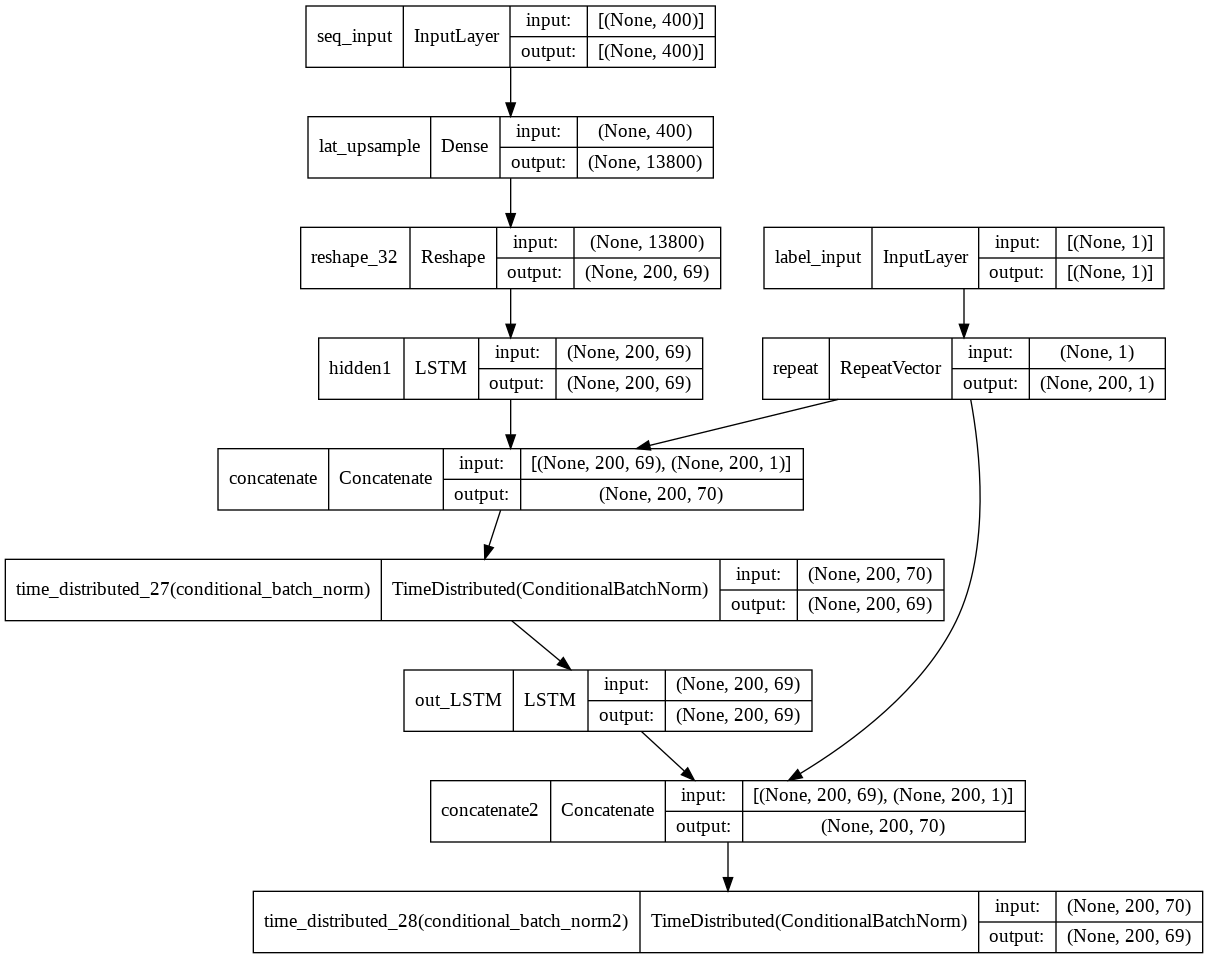

In [106]:
from keras.utils.vis_utils import plot_model
plot_model(gen, show_shapes=True, show_layer_names=True)


In [ ]:
! rm -rf /content/drive/MyDrive/CS490/models/WGAN2022.01.27-14:10:21

In [ ]:
! pip install tensorflow_addons

     |████████████████████████████████| 1.1 MB 5.0 MB/s 


In [ ]:
generator = define_generator(config)

In [ ]:
generator.summary()

Model: "generator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 seq_input (InputLayer)         [(None, 400)]        0           []                               
                                                                                                  
 lat_upsample (Dense)           (None, 27600)        11067600    ['seq_input[0][0]']              
                                                                                                  
 reshape_1 (Reshape)            (None, 400, 69)      0           ['lat_upsample[0][0]']           
                                                                                                  
 hidden1 (LSTM)                 (None, 400, 69)      38364       ['reshape_1[0][0]']              
                                                                                          

In [ ]:
import json
with open(os.path.join('/content/drive/MyDrive/CS490/models/WGAN_projection2022.01.27-14:14:48/epoch_2', 'train_metrics.txt')) as file:
  train_metrics = json.load(file)

<function matplotlib.pyplot.figure>

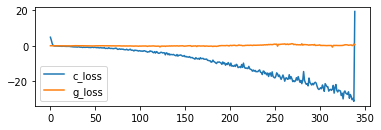

In [ ]:
Base_WGAN.plot_history(gan.train_metrics)

In [ ]:
import json
with open(os.path.join('/content/drive/MyDrive/CS490/models/WGAN_projection_instance_norm_2022.01.29-13:41:25/epoch_2', 'cm.txt')) as file:
  cm = json.load(file)